# Crédito y No Linealidad (Perú-like): OLS vs LSTAR/ESTAR vs MLP

Notebook autocontenido (Python) que implementa:

- Simulación mensual de datos “Perú-like” (2005–2024)
- Construcción de regresores (dependiente: Δlog(crédito))
- Modelos: **OLS**, **LSTAR (logística)**, **ESTAR (exponencial)**, **MLP**
- Diagnósticos: coeficientes (SE clásico y White), AIC/BIC, R², DW, Ljung–Box, Breusch–Pagan, Jarque–Bera
- Pruebas: **Teräsvirta** (linealidad), **Wald** (H₀: d=0), **Diebold–Mariano** (pronósticos)
- Validación **rolling** (expanding, 1-step ahead)
- (Opcional) **Bootstrap** para IC de (γ, c)
- Exportación a CSV/Excel y **figuras** PNG

Usa solo **matplotlib** (sin seaborn) y 1 gráfico por figura; no fija colores.


In [1]:
# Parámetros globales y librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import lstsq, inv, solve, norm
import math, os

TEST_FRAC = 0.25             # fracción de test
ROLL_START_FRACTION = 0.8    # inicio de rolling (proporción de muestra)
ENABLE_ROLLING_STAR = False  # True para incluir STAR/ESTAR en rolling (más lento)
RUN_BOOTSTRAP = False        # True para activar bootstrap de (gamma,c)
BOOTSTRAP_B = 200            # repeticiones bootstrap

OUTDIR = "/mnt/data/peru_like_star_results"
os.makedirs(OUTDIR, exist_ok=True)
OUTDIR

'/mnt/data/peru_like_star_results'

In [2]:
# Utilidades generales
def acf(x, nlags=20):
    x = np.asarray(x) - np.asarray(x).mean()
    den = float(x @ x) if float(x @ x) != 0 else 1.0
    ac = [1.0]
    for k in range(1, nlags+1):
        ac.append(float(x[:-k] @ x[k:]) / den if len(x)>k else 0.0)
    return np.array(ac)

def rmse(y_true, y_pred):
    r = np.asarray(y_true) - np.asarray(y_pred)
    return float(np.sqrt(np.mean(r**2)))

def mae(y_true, y_pred):
    r = np.asarray(y_true) - np.asarray(y_pred)
    return float(np.mean(np.abs(r)))

def train_test_split_time(X, y, test_frac=0.25):
    n = len(y); n_test = int(round(test_frac * n))
    return (X[:-n_test], y[:-n_test], X[-n_test:], y[-n_test:])

def durbin_watson(u):
    u = np.asarray(u); du = np.diff(u)
    denom = float(u @ u); num = float(du @ du)
    return float(num/denom) if denom>0 else float("nan")

def norm_sf(z):
    return 0.5*math.erfc(z/math.sqrt(2.0))

def chi2_sf_wilson(x, df):
    if df <= 0 or not np.isfinite(x):
        return float("nan")
    c = (x/df)**(1.0/3.0)
    mu = 1.0 - 2.0/(9.0*df)
    sig = math.sqrt(2.0/(9.0*df))
    z = (c - mu)/sig
    return norm_sf(z)

def acf_vals(x, nlags=20):
    x = np.asarray(x) - np.asarray(x).mean()
    den = float(x @ x) if float(x @ x) != 0 else 1.0
    ac = [1.0]
    for k in range(1, nlags+1):
        ac.append(float(x[:-k] @ x[k:]) / den if len(x)>k else 0.0)
    return np.array(ac)

def ljung_box(u, h=12):
    n = len(u)
    rho = acf_vals(u, nlags=h)[1:]
    Q = n*(n+2.0)*np.sum(rho**2 / (n - np.arange(1,h+1)))
    p = chi2_sf_wilson(Q, h)
    return float(Q), float(p)

def bp_test(X, u):
    n, k = X.shape
    y2 = (u**2).reshape(-1,1)
    beta = lstsq(X, y2, rcond=None)[0]
    y2hat = X @ beta
    ssr = float(np.sum( (y2hat - y2.mean())**2 ))
    sst = float(np.sum( (y2 - y2.mean())**2  ))
    R2 = ssr/sst if sst>0 else 0.0
    stat = n * R2
    df = k-1
    p = chi2_sf_wilson(stat, df)
    return stat, p, R2

def jarque_bera(u):
    n = len(u)
    if n<=0: return float("nan"), float("nan"), float("nan"), float("nan")
    m = u.mean(); s2 = np.mean((u-m)**2)
    if s2<=0: return float("nan"), float("nan"), float("nan"), float("nan")
    s = np.mean(((u-m)/math.sqrt(s2))**3)
    k = np.mean(((u-m)/math.sqrt(s2))**4)
    JB = n/6.0*(s**2) + n/24.0*((k-3.0)**2)
    p = chi2_sf_wilson(JB, 2)
    return float(JB), float(p), float(s), float(k)

def fit_stats_from_resid(y, yhat, n_params):
    resid = y - yhat
    n = len(y)
    sse = float(resid @ resid)
    s2 = sse / n
    tss = float(np.sum((y - y.mean())**2))
    r2 = 1.0 - sse/tss if tss>0 else float("nan")
    aic = n * math.log(s2) + 2*n_params
    bic = n * math.log(s2) + math.log(n) * n_params
    dw = durbin_watson(resid)
    Q, pQ = ljung_box(resid, h=12)
    BP, pBP, R2bp = bp_test(np.column_stack([np.ones(n), yhat]), resid)
    JB, pJB, skew, kurt = jarque_bera(resid)
    return {
        "n": n, "params": n_params, "SSE": sse, "sigma2": s2, "R2": r2,
        "AIC": aic, "BIC": bic, "DW": dw, "LBQ(12)": Q, "p_LBQ": pQ,
        "BP": BP, "p_BP": pBP, "JB": JB, "p_JB": pJB, "skew": skew, "kurt": kurt
    }


## 1) Simulación de datos mensuales “Perú-like” (2005–2024)

In [3]:
def simulate_peru_macro(T=240, seed=517):
    rng = np.random.default_rng(seed)
    cred = np.zeros(T+200)
    pi   = np.zeros(T+200)
    gap  = np.zeros(T+200)
    i    = np.zeros(T+200)
    fx   = np.zeros(T+200)
    copper = np.zeros(T+200)

    pi_target = 0.25
    i_star = 4.0

    for t in range(1, T+200):
        copper[t] = 0.30*copper[t-1] + rng.normal(0, 2.0)
        gap[t]    = 0.92*gap[t-1] + 0.08*(copper[t-1]/10.0) + rng.normal(0, 0.6)
        pi[t] = (0.65*pi[t-1] + 0.20*(pi_target - pi[t-1])
                 + 0.08*gap[t-1] + 0.06*fx[t-1] + rng.normal(0, 0.25))
        i[t] = (0.85*i[t-1] + 0.10*i_star
                + 0.50*(pi[t-1] - pi_target) + 0.15*gap[t-1] + rng.normal(0, 0.25))
        fx[t] = (0.70*fx[t-1] - 0.04*(i[t-1]-i_star) - 0.05*copper[t-1] + rng.normal(0, 0.6))
        dcred_lag = cred[t-1]-cred[t-2] if t>1 else 0.0
        x = np.array([1.0, dcred_lag, gap[t-1], pi[t-1], i[t-1], fx[t-1], copper[t-1]])
        b = np.array([0.15, 0.35, 0.08, -0.05, -0.06, -0.03, 0.01])
        d = np.array([0.00, 0.25, 0.12, -0.02, -0.04, -0.02, 0.00])
        gamma_true, c_true = 3.5, 0.0
        tstar = np.clip(gamma_true*(gap[t-1]-c_true), -35.0, 35.0)
        G = 1.0/(1.0 + np.exp(-tstar))
        dcred = b @ x + (d @ x)*G + rng.normal(0, 0.35)
        cred[t] = cred[t-1] + dcred

    idx = pd.date_range("2005-01-01", periods=T, freq="M")
    df = pd.DataFrame({
        "date": idx,
        "cred": cred[-T:], "pi": pi[-T:], "gap": gap[-T:],
        "i": i[-T:], "fx": fx[-T:], "copper": copper[-T:]
    }).set_index("date")
    df["dcred"] = df["cred"].diff().fillna(0.0)
    return df

df = simulate_peru_macro(T=240, seed=517)
df.head(10)

C:\Users\paulo.ramos\AppData\Local\Temp\ipykernel_25544\3794510730.py:31: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  idx = pd.date_range("2005-01-01", periods=T, freq="M")


,cred,pi,gap,i,fx,copper,dcred
date,,,,,,,
2005-01-31,4.759916,-0.056000,-0.655135,0.033246,1.536466,-1.946536,0.000000
2005-02-28,4.918902,-0.014410,-0.402446,0.420435,2.061881,0.381553,0.158986
2005-03-31,4.833910,-0.086728,-0.451536,0.464868,1.648318,-1.813400,-0.084992
2005-04-30,4.574887,0.130827,-0.002405,0.477802,0.636375,0.222934,-0.259023
2005-05-31,5.017773,0.696450,-0.027934,1.033375,0.731558,1.726361,0.442886
2005-06-30,5.183105,-0.061539,0.471989,1.392886,0.648265,-2.803747,0.165332
2005-07-31,6.318010,0.234973,0.553899,1.574775,1.002362,0.487494,1.134905
2005-08-31,7.109782,0.289907,1.036098,2.000949,1.562206,0.540066,0.791772
2005-09-30,7.862186,0.417592,-0.835197,2.072491,0.734329,-3.707027,0.752404


## 2) Construcción de regresores (Δcrédito como dependiente)

In [4]:
def build_regression_df(df, lags=2, dep="dcred", thr_var="gap", dropna=True):
    out = pd.DataFrame(index=df.index)
    out[dep] = df[dep]
    out["const"] = 1.0
    for L in range(1, lags+1):
        out[f"dcred_l{L}"]  = df["dcred"].shift(L)
        out[f"gap_l{L}"]    = df["gap"].shift(L)
        out[f"pi_l{L}"]     = df["pi"].shift(L)
        out[f"i_l{L}"]      = df["i"].shift(L)
        out[f"fx_l{L}"]     = df["fx"].shift(L)
        out[f"copper_l{L}"] = df["copper"].shift(L)
    out["z_thr"] = df[thr_var].shift(1)
    if dropna:
        out = out.dropna().reset_index()
    return out

regdf = build_regression_df(df, lags=2, dep="dcred", thr_var="gap", dropna=True)
y = regdf["dcred"].to_numpy(float)
X_cols = [c for c in regdf.columns if c not in ["dcred","z_thr","date"]]
X = regdf[X_cols].to_numpy(float)
z = regdf["z_thr"].to_numpy(float)
X_cols

['const',
 'dcred_l1',
 'gap_l1',
 'pi_l1',
 'i_l1',
 'fx_l1',
 'copper_l1',
 'dcred_l2',
 'gap_l2',
 'pi_l2',
 'i_l2',
 'fx_l2',
 'copper_l2']

## 3) OLS (benchmark lineal)

In [5]:
def fit_ols(X, y):
    beta = lstsq(X, y, rcond=None)[0]
    yhat = X @ beta
    resid = y - yhat
    n, k = X.shape
    s2 = (resid @ resid) / max(1, (n - k))
    cov = s2 * inv(X.T @ X)
    return {"beta": beta, "yhat": yhat, "resid": resid, "cov": cov}

ols = fit_ols(X, y)
ols["beta"], ols["cov"].shape

(array([ 0.25617958,  0.64812296,  0.13815587, -0.22420934, -0.01315624,
        -0.08021881,  0.00383444, -0.14445477, -0.0265802 ,  0.07817736,
        -0.07238094,  0.03595389, -0.0100247 ]),
 (13, 13))

## 4) STAR (LSTAR / ESTAR): funciones de transición y estimación robusta (LM)

In [6]:
def logistic_G(z, gamma, c):
    t = np.clip(gamma*(z - c), -35.0, 35.0)
    return 1.0/(1.0 + np.exp(-t))

def logistic_partials(z, gamma, c):
    t = np.clip(gamma*(z - c), -35.0, 35.0)
    G = 1.0/(1.0 + np.exp(-t))
    g_gamma = (z - c) * G * (1.0 - G)
    g_c     = -gamma * G * (1.0 - G)
    return G, g_gamma, g_c

def exponential_G(z, gamma, c):
    u = -gamma*(z - c)**2
    u = np.clip(u, -60.0, 0.0)
    return 1.0 - np.exp(u)

def exponential_partials(z, gamma, c):
    u = -gamma*(z - c)**2
    u = np.clip(u, -60.0, 0.0)
    expo = np.exp(u)
    G = 1.0 - expo
    g_gamma = (z - c)**2 * expo
    g_c     = -2.0 * gamma * (z - c) * expo
    return G, g_gamma, g_c

def star_fit_robust(X, y, z, kind="logistic", max_iter=800, tol=1e-7, lam0=5e-2):
    n, K = X.shape
    med = float(np.nanmedian(z))
    I1 = z <= med; I2 = ~I1
    b0 = lstsq(X[I1], y[I1], rcond=None)[0]
    b2 = lstsq(X[I2], y[I2], rcond=None)[0]
    d0 = b2 - b0
    gamma0, c0 = 1.0, med
    theta = np.concatenate([b0, d0, np.array([gamma0, c0])])
    lam = lam0; hist = []
    for it in range(max_iter):
        b = theta[:K]; d = theta[K:2*K]; gamma, c = float(theta[-2]), float(theta[-1])
        if kind=="logistic":
            G, g_gam, g_c = logistic_partials(z, gamma, c)
        else:
            gamma = max(gamma, 1e-6); theta[-2] = gamma
            G, g_gam, g_c = exponential_partials(z, gamma, c)
        Xd = X @ d; yhat = X @ b + Xd * G; r = y - yhat
        if not np.all(np.isfinite(r)):
            lam *= 10.0; continue
        J = np.zeros((n, 2*K + 2))
        J[:, :K]      = X
        J[:, K:2*K]   = (X.T * G).T
        J[:, -2]      = -Xd * g_gam
        J[:, -1]      = -Xd * g_c
        J = np.where(np.isfinite(J), J, 0.0)
        A = J.T @ J + lam * np.eye(J.shape[1])
        gvec = J.T @ r
        try:
            delta = solve(A, gvec)
        except Exception:
            delta = lstsq(A, gvec, rcond=None)[0]
        if not np.all(np.isfinite(delta)):
            lam *= 10.0; continue
        theta_new = theta + delta
        bN = theta_new[:K]; dN = theta_new[K:2*K]; gammaN, cN = float(theta_new[-2]), float(theta_new[-1])
        GN = logistic_G(z, gammaN, cN) if kind=="logistic" else exponential_G(z, max(gammaN,1e-6), cN)
        yhat_new = X @ bN + (X @ dN) * GN
        rss_old = float(r @ r); rss_new = float(np.sum((y - yhat_new)**2))
        hist.append({"iter": it, "RSS": rss_old, "lam": lam, "step_norm": float(norm(delta))})
        if (rss_new < rss_old) and np.isfinite(rss_new):
            theta = theta_new; lam = max(lam/3, 1e-9)
            if norm(delta) < tol: break
        else:
            lam *= 7.0
    b = theta[:K]; d = theta[K:2*K]; gamma, c = float(theta[-2]), float(theta[-1])
    if kind=="logistic":
        G, g_gam, g_c = logistic_partials(z, gamma, c)
    else:
        G, g_gam, g_c = exponential_partials(z, gamma, c)
    yhat = X @ b + (X @ d) * G; resid = y - yhat
    Xd = X @ d
    J = np.zeros((n, 2*K + 2))
    J[:, :K]      = X
    J[:, K:2*K]   = (X.T * G).T
    J[:, -2]      = -Xd * g_gam
    J[:, -1]      = -Xd * g_c
    J = np.where(np.isfinite(J), J, 0.0)
    JTJ = J.T @ J
    try:
        JTJ_inv = inv(JTJ)
    except Exception:
        JTJ_inv = np.linalg.pinv(JTJ)
    meat = J.T @ (J * (resid[:, None]**2))
    cov_white = JTJ_inv @ meat @ JTJ_inv
    return {"theta": theta, "b": b, "d": d, "gamma": gamma, "c": c, "G": G,
            "yhat": yhat, "resid": resid, "cov_white": cov_white,
            "history": pd.DataFrame(hist)}

lstar_full = star_fit_robust(X, y, z, kind="logistic")
estar_full = star_fit_robust(X, y, z, kind="exponential")
lstar_full["gamma"], lstar_full["c"], estar_full["gamma"], estar_full["c"]

(0.9664704736753051,
 -0.18475460146351294,
 1.4283787643500487,
 0.7423665214978394)

## 5) Tablas de coeficientes, estadísticos y pruebas (OLS / LSTAR / ESTAR)

In [7]:
def ols_coeftable(X, y, X_cols, beta):
    n, k = X.shape
    yhat = X @ beta
    resid = y - yhat
    s2 = float(resid @ resid) / max(1, (n - k))
    cov = s2 * inv(X.T @ X)
    se = np.sqrt(np.diag(cov))
    tvals = beta / se
    pvals = [2*norm_sf(abs(t)) for t in tvals]
    meat = X.T @ (X * (resid[:,None]**2))
    cov_white = inv(X.T @ X) @ meat @ inv(X.T @ X)
    seW = np.sqrt(np.diag(cov_white))
    tW = beta / seW
    pW = [2*norm_sf(abs(t)) for t in tW]
    tab = pd.DataFrame({
        "var": X_cols, "beta": beta, "SE": se, "t": tvals, "p": pvals,
        "SE_White": seW, "t_White": tW, "p_White": pW
    })
    stats = fit_stats_from_resid(y, yhat, n_params=len(beta))
    return tab, pd.DataFrame([stats])

def star_coeftable(fit, X_cols):
    theta = fit["theta"]; cov = fit["cov_white"]
    se = np.sqrt(np.diag(cov))
    names = [f"b:{c}" for c in X_cols] + [f"d:{c}" for c in X_cols] + ["gamma","c"]
    tvals = theta / se
    pvals = [2*norm_sf(abs(t)) for t in tvals]
    tab = pd.DataFrame({"param":names, "estimate":theta, "SE_White":se, "t":tvals, "p":pvals})
    stats = fit_stats_from_resid(y, fit["yhat"], n_params=len(theta))
    stats_df = pd.DataFrame([stats])
    K = len(X_cols)
    dvec = theta[K:2*K]
    cov_d = cov[K:2*K, K:2*K]
    try:
        W = float(dvec.T @ inv(cov_d) @ dvec)
        pW = chi2_sf_wilson(W, K)
    except Exception:
        W, pW = float("nan"), float("nan")
    wald = pd.DataFrame([{"Wald_H0_d=0": W, "df": K, "p": pW}])
    return tab, stats_df, wald

ols_tab, ols_stats = ols_coeftable(X, y, X_cols, ols["beta"])
lstar_tab, lstar_stats, lstar_wald = star_coeftable(lstar_full, X_cols)
estar_tab, estar_stats, estar_wald = star_coeftable(estar_full, X_cols)
ols_tab.head(), lstar_tab.tail(5), estar_tab.tail(5)

(        var      beta        SE         t             p  SE_White   t_White  \
 0     const  0.256180  0.071288  3.593594  3.261482e-04  0.071598  3.578043   
 1  dcred_l1  0.648123  0.066905  9.687148  3.419431e-22  0.066653  9.723888   
 2    gap_l1  0.138156  0.038385  3.599241  3.191468e-04  0.032904  4.198732   
 3     pi_l1 -0.224209  0.087410 -2.565038  1.031645e-02  0.078945 -2.840075   
 4      i_l1 -0.013156  0.088619 -0.148458  8.819812e-01  0.094060 -0.139871   
 
         p_White  
 0  3.461759e-04  
 1  2.384964e-22  
 2  2.684139e-05  
 3  4.510292e-03  
 4  8.887619e-01  ,
           param  estimate  SE_White         t         p
 23       d:i_l2 -0.296278  0.641410 -0.461916  0.644141
 24      d:fx_l2 -0.009852  0.187880 -0.052440  0.958178
 25  d:copper_l2  0.035104  0.074820  0.469183  0.638939
 26        gamma  0.966470  2.337917  0.413390  0.679321
 27            c -0.184755  1.982649 -0.093186  0.925756,
           param  estimate  SE_White         t         p
 23

### Prueba de linealidad (Teräsvirta-style LM con p-valor aprox.)

In [8]:
def terasvirta_LM_with_p(X, y, z):
    beta = lstsq(X, y, rcond=None)[0]
    e = y - X @ beta
    Z = np.hstack([(X.T * (z**m)).T for m in (1,2,3)])
    n, K = X.shape
    XtX_inv = inv(X.T @ X)
    Mx = np.eye(n) - X @ XtX_inv @ X.T
    e_tilde = Mx @ e
    Z_tilde = Mx @ Z
    beta_aux = lstsq(Z_tilde, e_tilde, rcond=None)[0]
    resid_aux = e_tilde - Z_tilde @ beta_aux
    R2 = 1.0 - float(resid_aux @ resid_aux) / float(e_tilde @ e_tilde)
    LM = n * R2
    df = Z.shape[1]
    p = chi2_sf_wilson(LM, df)
    return {"LM": LM, "df": df, "p": p, "R2_partial": R2}

pd.DataFrame([terasvirta_LM_with_p(X, y, z)])

,LM,df,p,R2_partial
0,35.931392,39,0.610836,0.150972


## 6) MLP (red neuronal) como comparador

In [9]:
def fit_mlp(X, y, test_frac=TEST_FRAC, random_state=7):
    try:
        from sklearn.preprocessing import StandardScaler
        from sklearn.neural_network import MLPRegressor
        n = len(y); n_test = int(round(test_frac * n))
        Xtr, ytr = X[:-n_test], y[:-n_test]; Xte, yte = X[-n_test:], y[-n_test:]
        ss = StandardScaler(); Xtr_s = ss.fit_transform(Xtr); Xte_s = ss.transform(Xte)
        mlp = MLPRegressor(hidden_layer_sizes=(32,16), activation="tanh",
                           alpha=1e-4, solver="adam", learning_rate_init=1e-3,
                           max_iter=4000, random_state=random_state)
        mlp.fit(Xtr_s, ytr)
        yhat_tr = mlp.predict(Xtr_s); yhat_te = mlp.predict(Xte_s)
        return {"backend":"sklearn", "yhat_tr":yhat_tr, "yhat_te":yhat_te, "ytr":ytr, "yte":yte}
    except Exception:
        n = len(y); n_test = int(round(test_frac * n))
        Xtr, ytr = X[:-n_test], y[:-n_test]; Xte, yte = X[-n_test:], y[-n_test:]
        mu = Xtr.mean(axis=0); sd = Xtr.std(axis=0) + 1e-8
        Xtr_s = (Xtr - mu)/sd; Xte_s = (Xte - mu)/sd
        rng = np.random.default_rng(7); D, H1, H2 = X.shape[1], 32, 16
        W1 = rng.normal(0, 0.1, size=(D, H1)); b1 = np.zeros(H1)
        W2 = rng.normal(0, 0.1, size=(H1, H2)); b2 = np.zeros(H2)
        W3 = rng.normal(0, 0.1, size=(H2, 1));  b3 = np.zeros(1)
        lr = 1e-3
        for it in range(6000):
            h1 = np.tanh(Xtr_s @ W1 + b1)
            h2 = np.tanh(h1 @ W2 + b2)
            yhat = (h2 @ W3 + b3).ravel()
            r = ytr - yhat
            dW3 = -(h2.T @ r[:,None]) / len(ytr); db3 = -r.mean()
            dh2 = r[:,None] @ W3.T; dact2 = (1 - h2**2)*dh2
            dW2 = -(h1.T @ dact2) / len(ytr); db2 = -dact2.mean(axis=0)
            dh1 = dact2 @ W2.T; dact1 = (1 - h1**2)*dh1
            dW1 = -(Xtr_s.T @ dact1) / len(ytr); db1 = -dact1.mean(axis=0)
            W3 -= lr*dW3; b3 -= lr*db3; W2 -= lr*dW2; b2 -= lr*db2; W1 -= lr*dW1; b1 -= lr*db1
        yhat_tr = (np.tanh(np.tanh(Xtr_s @ W1 + b1) @ W2 + b2) @ W3 + b3).ravel()
        yhat_te = (np.tanh(np.tanh(Xte_s @ W1 + b1) @ W2 + b2) @ W3 + b3).ravel()
        return {"backend":"numpy", "yhat_tr":yhat_tr, "yhat_te":yhat_te, "ytr":ytr, "yte":yte}

mlp = fit_mlp(X, y, test_frac=TEST_FRAC, random_state=7)
mlp["backend"], rmse(mlp["yte"], mlp["yhat_te"])

('sklearn', 0.3171128159030037)

## 7) Split temporal (train/test), predicciones OOS y Diebold–Mariano

In [10]:
def star_predict(fit, Xnew, znew, kind="logistic"):
    b, d, gamma, c = fit["b"], fit["d"], fit["gamma"], fit["c"]
    G = logistic_G(znew, gamma, c) if kind=="logistic" else exponential_G(znew, gamma, c)
    return Xnew @ b + (Xnew @ d) * G

Xtr, ytr, Xte, yte = train_test_split_time(X, y, test_frac=TEST_FRAC)
ztr, zte = train_test_split_time(z, y, test_frac=TEST_FRAC)[0::2]

# OLS
beta_tr = lstsq(Xtr, ytr, rcond=None)[0]
yhat_ols_te = Xte @ beta_tr
e_ols = yte - yhat_ols_te

# STAR train → test
lstar_tr = star_fit_robust(Xtr, ytr, ztr, kind="logistic")
estar_tr = star_fit_robust(Xtr, ytr, ztr, kind="exponential")
yhat_lstar_te = star_predict(lstar_tr, Xte, zte, "logistic")
yhat_estar_te = star_predict(estar_tr, Xte, zte, "exponential")
e_lstar = yte - yhat_lstar_te
e_estar = yte - yhat_estar_te

# MLP ya calculada en toda la muestra (usa mismo corte test)
e_mlp = mlp["yte"] - mlp["yhat_te"]

perf = pd.DataFrame({
    "Model":["OLS","LSTAR","ESTAR","MLP("+mlp["backend"]+")"],
    "RMSE_test":[rmse(yte, yhat_ols_te), rmse(yte, yhat_lstar_te), rmse(yte, yhat_estar_te), rmse(mlp["yte"], mlp["yhat_te"])],
    "MAE_test":[mae(yte, yhat_ols_te), mae(yte, yhat_lstar_te), mae(yte, yhat_estar_te), mae(mlp["yte"], mlp["yhat_te"])],
})
perf


,Model,RMSE_test,MAE_test
0,OLS,0.300172,0.239618
1,LSTAR,0.301070,0.241150
2,ESTAR,0.296682,0.240861
3,MLP(sklearn),0.317113,0.266514


In [11]:
def dm_test(e1, e2, h=1, power=2, lag=None):
    e1 = np.asarray(e1); e2 = np.asarray(e2)
    if power == 2:
        d = e1**2 - e2**2
    elif power == 1:
        d = np.abs(e1) - np.abs(e2)
    else:
        d = np.abs(e1)**power - np.abs(e2)**power
    T = len(d); d = d - d.mean()
    if lag is None:
        lag = int(np.floor(T**(1/3)))
    gamma0 = float(np.dot(d, d)) / T
    var = gamma0
    for j in range(1, lag+1):
        w = 1.0 - j/(lag+1.0)
        cov = float(np.dot(d[j:], d[:-j])) / T
        var += 2*w*cov
    dm = d.mean() / math.sqrt(var/T)
    p = 2*norm_sf(abs(dm))
    return float(dm), float(p)

pairs = [("OLS","LSTAR", e_ols, e_lstar), ("OLS","ESTAR", e_ols, e_estar), ("LSTAR","ESTAR", e_lstar, e_estar)]
dm_rows = []
for a,b,ea,eb in pairs:
    dm2, p2 = dm_test(ea, eb, power=2)
    dm1, p1 = dm_test(ea, eb, power=1)
    dm_rows.append({"A":a, "B":b, "DM_sq":dm2, "p_sq":p2, "DM_abs":dm1, "p_abs":p1})
pd.DataFrame(dm_rows)

,A,B,DM_sq,p_sq,DM_abs,p_abs
0,OLS,LSTAR,8.355366e-17,1.0,-1.088129e-16,1.0
1,OLS,ESTAR,0.000000e+00,1.0,5.919247e-17,1.0
2,LSTAR,ESTAR,-1.240863e-16,1.0,-8.200481e-17,1.0


## 8) Validación rolling (expanding, 1-step ahead)

In [12]:
def rolling_forecast_1step(X, y, z, start_fraction=ROLL_START_FRACTION, enable_star=ENABLE_ROLLING_STAR):
    from math import floor
    n = len(y); start = int(floor(start_fraction * n))
    preds = {"OLS":[], "y":[]}
    if enable_star:
        preds["LSTAR"] = []; preds["ESTAR"] = []
    for t in range(start, n):
        Xtrain, ytrain, ztrain = X[:t], y[:t], z[:t]
        x_t, z_t = X[t:t+1], z[t:t+1]
        beta = lstsq(Xtrain, ytrain, rcond=None)[0]
        preds["OLS"].append(float(x_t @ beta))
        if enable_star:
            lfit = star_fit_robust(Xtrain, ytrain, ztrain, kind="logistic", max_iter=300)
            efit = star_fit_robust(Xtrain, ytrain, ztrain, kind="exponential", max_iter=300)
            preds["LSTAR"].append(float(star_predict(lfit, x_t, z_t, "logistic")))
            preds["ESTAR"].append(float(star_predict(efit, x_t, z_t, "exponential")))
        preds["y"].append(float(y[t]))
    return pd.DataFrame(preds)

roll_df = rolling_forecast_1step(X, y, z, start_fraction=ROLL_START_FRACTION, enable_star=ENABLE_ROLLING_STAR)
roll_df["e_OLS"] = roll_df["y"] - roll_df["OLS"]
if ENABLE_ROLLING_STAR:
    roll_df["e_LSTAR"] = roll_df["y"] - roll_df["LSTAR"]
    roll_df["e_ESTAR"] = roll_df["y"] - roll_df["ESTAR"]

roll_perf_rows = [{"Model":"OLS", "RMSE": rmse(roll_df["y"], roll_df["OLS"]), "MAE": mae(roll_df["y"], roll_df["OLS"]) }]
if ENABLE_ROLLING_STAR:
    roll_perf_rows += [
        {"Model":"LSTAR", "RMSE": rmse(roll_df["y"], roll_df["LSTAR"]), "MAE": mae(roll_df["y"], roll_df["LSTAR"]) },
        {"Model":"ESTAR", "RMSE": rmse(roll_df["y"], roll_df["ESTAR"]), "MAE": mae(roll_df["y"], roll_df["ESTAR"]) }
    ]
pd.DataFrame(roll_perf_rows)

C:\Users\paulo.ramos\AppData\Local\Temp\ipykernel_25544\4129145811.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  preds["OLS"].append(float(x_t @ beta))


,Model,RMSE,MAE
0,OLS,0.313495,0.25804


## 9) (Opcional) Bootstrap para IC de (γ, c)

In [13]:
def bootstrap_gamma_c(X, y, z, kind="logistic", B=200, seed=1234):
    rng = np.random.default_rng(seed)
    fit0 = star_fit_robust(X, y, z, kind=kind)
    yhat0 = fit0["yhat"]; resid0 = y - yhat0
    gc = []
    for b in range(B):
        e_star = rng.choice(resid0, size=len(resid0), replace=True)
        y_star = yhat0 + e_star
        fit_b = star_fit_robust(X, y_star, z, kind=kind, max_iter=400)
        gc.append([fit_b["gamma"], fit_b["c"]])
    return fit0, np.array(gc)

if RUN_BOOTSTRAP:
    fitL, bootL = bootstrap_gamma_c(X, y, z, "logistic", B=BOOTSTRAP_B, seed=123)
    fitE, bootE = bootstrap_gamma_c(X, y, z, "exponential", B=BOOTSTRAP_B, seed=456)
    def ci(arr):
        lo, hi = np.percentile(arr, [2.5, 97.5]); return float(lo), float(hi)
    gl_ci = ci(bootL[:,0]); cl_ci = ci(bootL[:,1])
    ge_ci = ci(bootE[:,0]); ce_ci = ci(bootE[:,1])
    pd.DataFrame({
        "Model":["LSTAR","LSTAR","ESTAR","ESTAR"],
        "Param":["gamma","c","gamma","c"],
        "CI_low":[gl_ci[0], cl_ci[0], ge_ci[0], ce_ci[0]],
        "CI_high":[gl_ci[1], cl_ci[1], ge_ci[1], ce_ci[1]]
    })
else:
    print("Bootstrap desactivado. Cambia RUN_BOOTSTRAP=True para ejecutarlo.")

Bootstrap desactivado. Cambia RUN_BOOTSTRAP=True para ejecutarlo.


## 10) Gráficos (series, transición, fit in-sample, ACF, dispersión OOS) y exportación a CSV/Excel/PNG

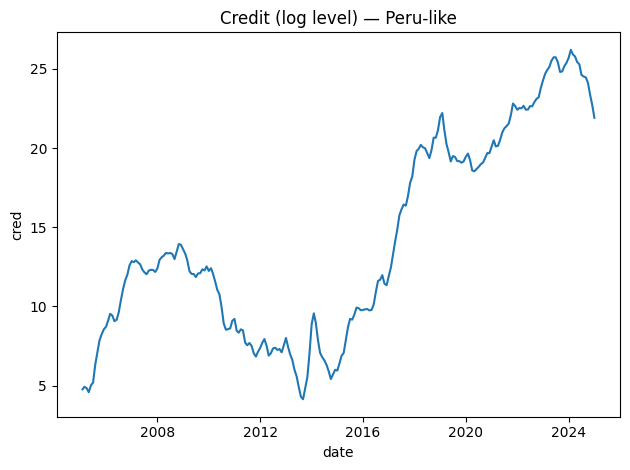

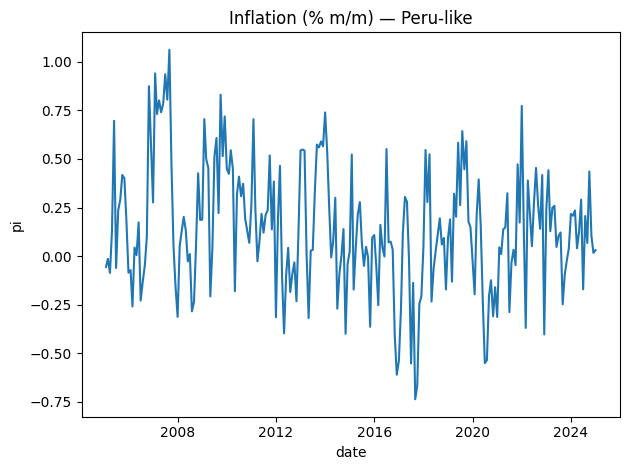

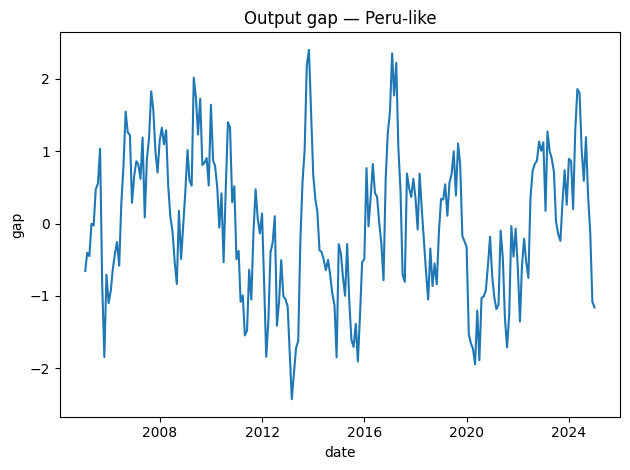

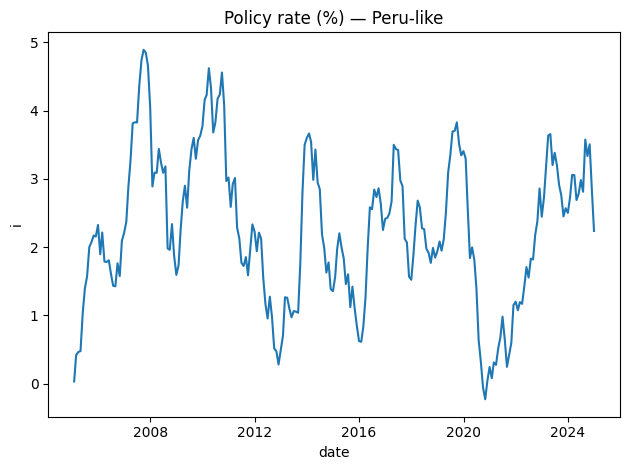

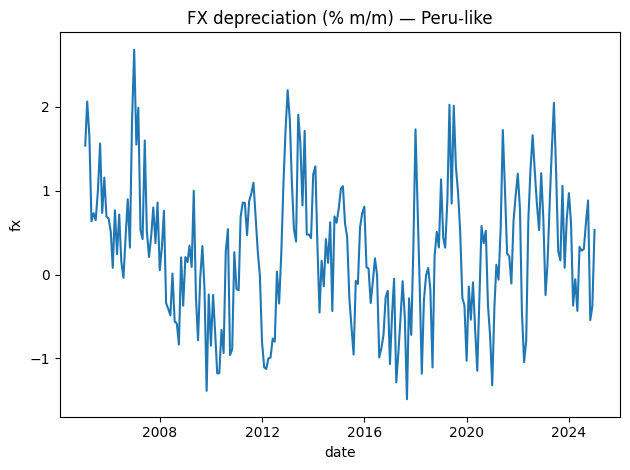

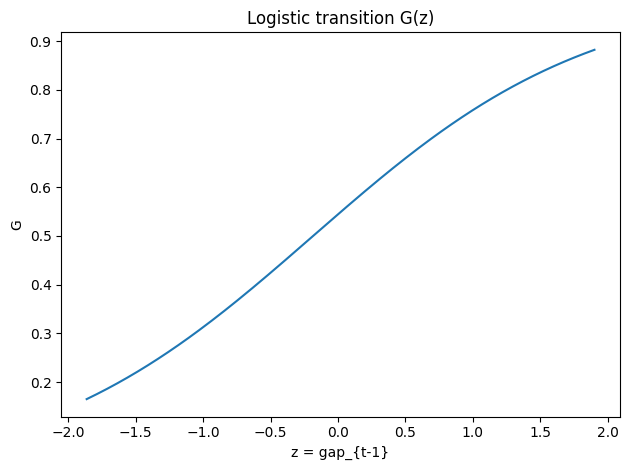

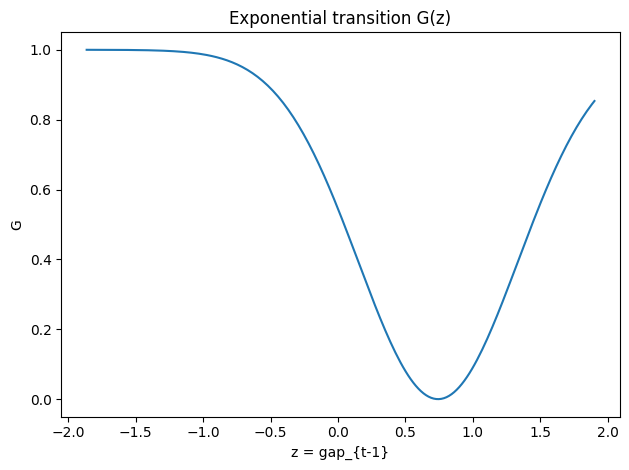

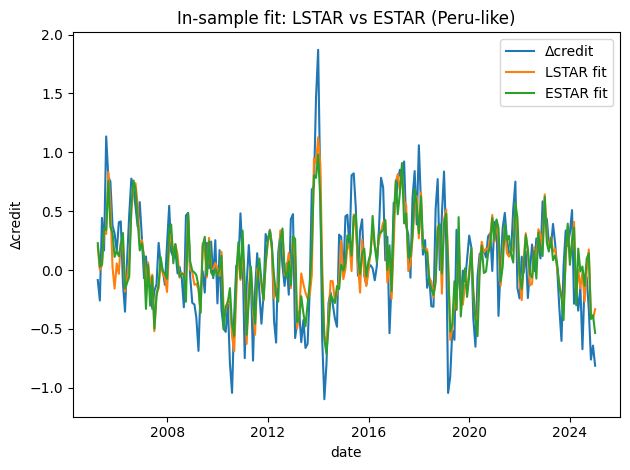

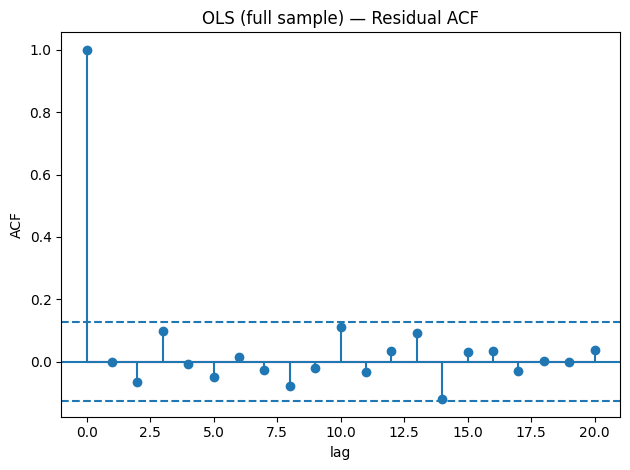

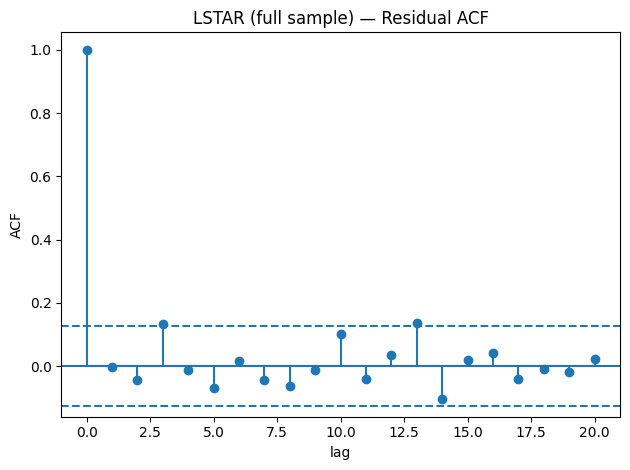

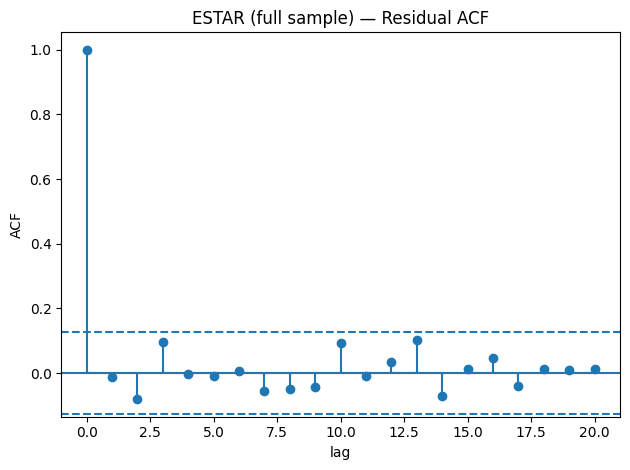

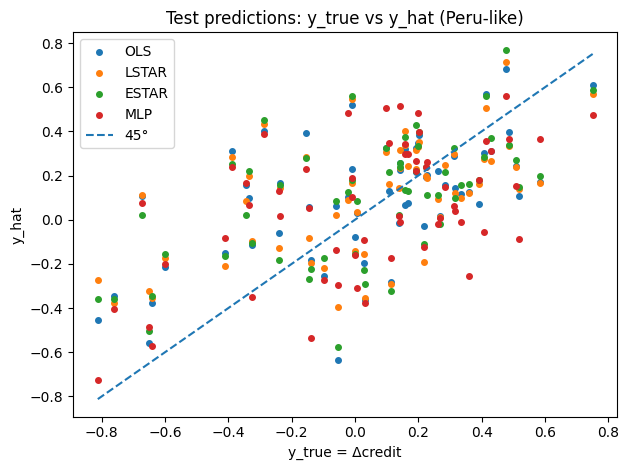

Exportado en: /mnt/data/peru_like_star_results


In [14]:
# Series
plt.figure(); plt.plot(df.index, df["cred"]); plt.title("Credit (log level) — Peru-like"); plt.xlabel("date"); plt.ylabel("cred"); plt.tight_layout(); plt.savefig(os.path.join(OUTDIR, "series_credit.png")); plt.show()
plt.figure(); plt.plot(df.index, df["pi"]);   plt.title("Inflation (% m/m) — Peru-like"); plt.xlabel("date"); plt.ylabel("pi"); plt.tight_layout(); plt.savefig(os.path.join(OUTDIR, "series_pi.png")); plt.show()
plt.figure(); plt.plot(df.index, df["gap"]);  plt.title("Output gap — Peru-like"); plt.xlabel("date"); plt.ylabel("gap"); plt.tight_layout(); plt.savefig(os.path.join(OUTDIR, "series_gap.png")); plt.show()
plt.figure(); plt.plot(df.index, df["i"]);    plt.title("Policy rate (%) — Peru-like"); plt.xlabel("date"); plt.ylabel("i"); plt.tight_layout(); plt.savefig(os.path.join(OUTDIR, "series_rate.png")); plt.show()
plt.figure(); plt.plot(df.index, df["fx"]);   plt.title("FX depreciation (% m/m) — Peru-like"); plt.xlabel("date"); plt.ylabel("fx"); plt.tight_layout(); plt.savefig(os.path.join(OUTDIR, "series_fx.png")); plt.show()

# Transiciones full-sample
zz = np.linspace(np.percentile(z, 2), np.percentile(z, 98), 200)
G_log = logistic_G(zz, lstar_full["gamma"], lstar_full["c"]) ; G_exp = exponential_G(zz, estar_full["gamma"], estar_full["c"])
plt.figure(); plt.plot(zz, G_log); plt.title("Logistic transition G(z)"); plt.xlabel("z = gap_{t-1}"); plt.ylabel("G"); plt.tight_layout(); plt.savefig(os.path.join(OUTDIR, "transition_logistic.png")); plt.show()
plt.figure(); plt.plot(zz, G_exp); plt.title("Exponential transition G(z)"); plt.xlabel("z = gap_{t-1}"); plt.ylabel("G"); plt.tight_layout(); plt.savefig(os.path.join(OUTDIR, "transition_exponential.png")); plt.show()

# Ajuste in-sample
plt.figure();
plt.plot(regdf["date"], y, label="Δcredit");
plt.plot(regdf["date"], lstar_full["yhat"], label="LSTAR fit");
plt.plot(regdf["date"], estar_full["yhat"], label="ESTAR fit");
plt.title("In-sample fit: LSTAR vs ESTAR (Peru-like)"); plt.xlabel("date"); plt.ylabel("Δcredit"); plt.legend(); plt.tight_layout(); plt.savefig(os.path.join(OUTDIR, "insample_fit.png")); plt.show()

# ACF residuales
def plot_resid_acf_and_save(resid, title, fname, nlags=20):
    ac = acf(resid, nlags=nlags); x = np.arange(len(ac))
    plt.figure();
    try:
        plt.stem(x, ac, use_line_collection=True)
    except TypeError:
        plt.stem(x, ac)
    plt.axhline(0)
    band = 1.96/np.sqrt(len(resid)) if len(resid)>0 else 0.0
    plt.axhline(band, linestyle="--"); plt.axhline(-band, linestyle="--")
    plt.title(title + " — Residual ACF"); plt.xlabel("lag"); plt.ylabel("ACF"); plt.tight_layout(); plt.savefig(os.path.join(OUTDIR, fname)); plt.show()

plot_resid_acf_and_save(ols["resid"], "OLS (full sample)", "acf_resid_ols.png")
plot_resid_acf_and_save(lstar_full["resid"], "LSTAR (full sample)", "acf_resid_lstar.png")
plot_resid_acf_and_save(estar_full["resid"], "ESTAR (full sample)", "acf_resid_estar.png")

# Dispersión OOS
plt.figure();
plt.scatter(yte, yhat_ols_te, s=16, label="OLS")
plt.scatter(yte, yhat_lstar_te, s=16, label="LSTAR")
plt.scatter(yte, yhat_estar_te, s=16, label="ESTAR")
plt.scatter(mlp["yte"], mlp["yhat_te"], s=16, label="MLP")
mn = float(min(yte.min(), mlp["yte"].min())); mx = float(max(yte.max(), mlp["yte"].max()))
plt.plot([mn, mx], [mn, mx], linestyle="--", label="45°")
plt.title("Test predictions: y_true vs y_hat (Peru-like)"); plt.xlabel("y_true = Δcredit"); plt.ylabel("y_hat"); plt.legend(); plt.tight_layout(); plt.savefig(os.path.join(OUTDIR, "oos_scatter.png")); plt.show()

# Exportar tablas clave
ols_tab.to_csv(os.path.join(OUTDIR, "ols_coef.csv"), index=False)
ols_stats.to_csv(os.path.join(OUTDIR, "ols_stats.csv"), index=False)
lstar_tab.to_csv(os.path.join(OUTDIR, "lstar_coef.csv"), index=False)
lstar_stats.to_csv(os.path.join(OUTDIR, "lstar_stats.csv"), index=False)
lstar_wald.to_csv(os.path.join(OUTDIR, "lstar_wald.csv"), index=False)
estar_tab.to_csv(os.path.join(OUTDIR, "estar_coef.csv"), index=False)
estar_stats.to_csv(os.path.join(OUTDIR, "estar_stats.csv"), index=False)
estar_wald.to_csv(os.path.join(OUTDIR, "estar_wald.csv"), index=False)
pd.DataFrame(dm_rows).to_csv(os.path.join(OUTDIR, "diebold_mariano.csv"), index=False)
perf.to_csv(os.path.join(OUTDIR, "oos_performance.csv"), index=False)
roll_df.to_csv(os.path.join(OUTDIR, "rolling_1step_predictions.csv"), index=False)

with pd.ExcelWriter(os.path.join(OUTDIR, "regression_summary.xlsx")) as xl:
    ols_tab.to_excel(xl, sheet_name="OLS_coef", index=False)
    ols_stats.to_excel(xl, sheet_name="OLS_stats", index=False)
    lstar_tab.to_excel(xl, sheet_name="LSTAR_coef", index=False)
    lstar_stats.to_excel(xl, sheet_name="LSTAR_stats", index=False)
    lstar_wald.to_excel(xl, sheet_name="LSTAR_wald", index=False)
    estar_tab.to_excel(xl, sheet_name="ESTAR_coef", index=False)
    estar_stats.to_excel(xl, sheet_name="ESTAR_stats", index=False)
    estar_wald.to_excel(xl, sheet_name="ESTAR_wald", index=False)
    pd.DataFrame(dm_rows).to_excel(xl, sheet_name="DieboldMariano", index=False)
    pd.DataFrame(roll_df.describe()).to_excel(xl, sheet_name="Rolling_summary")

print("Exportado en:", OUTDIR)

### Notas
- Para activar **rolling con STAR/ESTAR**, pon `ENABLE_ROLLING_STAR=True` al inicio.
- Para correr **bootstrap** de (γ, c), setea `RUN_BOOTSTRAP=True` (puede tardar si `BOOTSTRAP_B` es grande).
- Para usar datos reales, reemplaza la celda de simulación por tu propio `DataFrame` y asegúrate de crear `dcred` y `z_thr`.
